<a href="https://colab.research.google.com/github/1rd0/18lab_bek/blob/master/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%9D%D0%A1_%E2%84%96_6_ipynb__(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №5

**Оптимизация параметров нейронной сети в Keras с использованием KerasTuner**

---

**Впишите в эту ячейку ваши ФИО, группу и вариант**.

ФИО:Рабдел Дмитрй Александрович

Группа:221-371

---

 Keras Tuner
 — это библиотека, которая реализует методы для настройки оптимального набора гиперпараметров модели в TensorFlow.
Процесс выбора правильного набора гиперпараметров
 называется настройкой гиперпараметров или гипернастройкой .


В данной работе будем использовать экземпляр тюнера для выполнения гипернастройки Keras-Tuner Hyperband.  (документация https://keras.io/api/keras_tuner/tuners/hyperband/)

Чтобы создать экземпляр тюнера Hyperband, необходимо указать гипермодель, objective оптимизации и максимальное количество эпох для обучения ( max_epochs ).
2. Создание модели для гипернастройки – определение пространства поиска гиперпараметров в дополнение к архитектуре модели.
Модель, созданная для гипернастройки, называется гипермоделью .
Построение гипермодели с помощью двух подходов:
1. С использованием функции построения модели
2. Путем создания подкласса класса HyperModel API Keras Tuner.
В данной работе будем создавать модель с использованием функции (1 подход)


Основные этапы гипернастройки с использованием Keras Tuner
1. Установка Keras-Tuner.
2. Создание гипермодели  Keras-Tuner.  
3. Создание  экземпляра тюнера и гипернастройка.
4. Алгоритм настройки Hyperband.
5. Запуск процесса поиска параметров.
6. Создание оптимальной модели.


In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV


1. Установка Keras-Tuner.

In [3]:
pip install -q -U keras-tuner

In [4]:
import keras_tuner as kt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


2. Загрузка датасета fashion_mnist

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [8]:
# Нормализация данных
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot кодирование меток
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

2. Создание гипермодели  Keras-Tuner.  

In [9]:
# Определение гипермодели
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

3. Создание  экземпляра тюнера и гипернастройка.

In [11]:
from keras_tuner import Hyperband

# Создание экземпляра тюнера Hyperband
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='hyperband_dir',
    project_name='cifar10_tuning'
)

Reloading Tuner from hyperband_dir/cifar10_tuning/tuner0.json


4. Алгоритм настройки Hyperband.

In [12]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


5. Запуск процесса поиска параметров.

In [17]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_tuner import Hyperband
# Запуск поиска гиперпараметров
tuner.search(x_train, y_train,
             epochs=4,
             validation_split=0.2,
             callbacks=[stop_early])

# Вывод лучших гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Оптимальные параметры:
Количество фильтров в первом сверточном слое: {best_hps.get('conv_1_filters')}
Размер ядра в первом сверточном слое: {best_hps.get('conv_1_kernel')}
Количество фильтров во втором сверточном слое: {best_hps.get('conv_2_filters')}
Размер ядра во втором сверточном слое: {best_hps.get('conv_2_kernel')}
Количество нейронов в полносвязном слое: {best_hps.get('dense_units')}
Уровень dropout: {best_hps.get('dropout_rate')}
Оптимальное значение learning rate: {best_hps.get('learning_rate')}
""")

Trial 36 Complete [00h 04m 06s]
val_accuracy: 0.6744999885559082

Best val_accuracy So Far: 0.6876000165939331
Total elapsed time: 03h 20m 24s

Search: Running Trial #37

Value             |Best Value So Far |Hyperparameter
64                |96                |conv_1_filters
3                 |3                 |conv_1_kernel
128               |96                |conv_2_filters
5                 |3                 |conv_2_kernel
256               |256               |dense_units
0.3               |0.3               |dropout_rate
0.001             |0.001             |learning_rate
4                 |4                 |tuner/epochs
2                 |2                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
1                 |1                 |tuner/round
0009              |0004              |tuner/trial_id

Epoch 3/4
 692/1250 [===============>..............] - ETA: 1:28 - loss: 1.0254 - accuracy: 0.6378

KeyboardInterrupt: 

6. Создание оптимальной модели.

In [18]:
# Создане оптимальной модели и обучение
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train,
                    epochs=30,
                    validation_split=0.2,
                    callbacks=[stop_early])

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f'Best test accuracy: {test_accuracy}')
model.summary()

NameError: name 'best_hps' is not defined

Построение графа оптимальной модели.

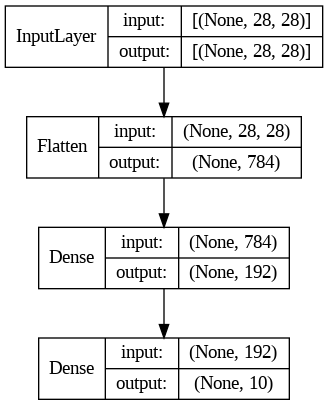

In [ ]:
# Визуализация результатов обучения
import matplotlib.pyplot as plt

# График точности модели
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# График потерь модели
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Обучение оптимальной модели на лучшем колиестве эпох
hypermodel = tuner.hypermodel.build(best_hps)

# обучение
history=hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/48
1500/1500 [==============================] - 6s 3ms/step - loss: 1.0966 - accuracy: 0.6578 - val_loss: 0.6998 - val_accuracy: 0.7520
Epoch 2/48
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6416 - accuracy: 0.7680 - val_loss: 0.5936 - val_accuracy: 0.7801
Epoch 3/48
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5655 - accuracy: 0.7974 - val_loss: 0.5438 - val_accuracy: 0.8036
Epoch 4/48
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5227 - accuracy: 0.8149 - val_loss: 0.5114 - val_accuracy: 0.8163
Epoch 5/48
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4949 - accuracy: 0.8257 - val_loss: 0.4936 - val_accuracy: 0.8231
Epoch 6/48
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4748 - accuracy: 0.8341 - val_loss: 0.4710 - val_accuracy: 0.8317
Epoch 7/48
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4593 - accuracy: 0.8395 - val_loss: 0.4641 - val_accuracy:

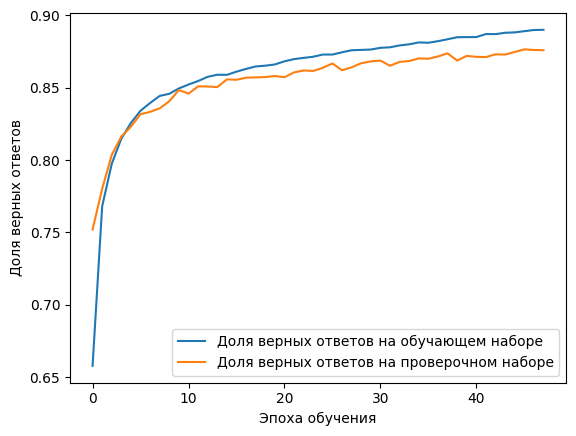

In [ ]:
# Построение графиков
import matplotlib.pyplot as plt

# Построение графика точности на обучающей выборке
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Построение графика точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей.
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()


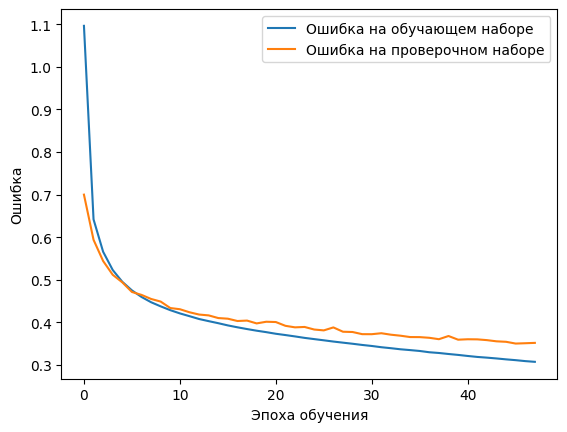

In [ ]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')

plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()

In [ ]:
# Оценка оптимальной модели
eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.3778 - accuracy: 0.8663
[test loss, test accuracy]: [0.3778300881385803, 0.8662999868392944]


 **Задание**

Для датасета CIFAR-10 провести гипернастройку модели нейронной сети с использованием  Keras-Tuner

Этапы
1. Загрузить датасет CIFAR-10 (ссылка на описание датасета https://keras.io/api/datasets/cifar10/)
2. Установить Keras-Tuner.
3. Создание гипермодели Keras-Tuner.
4. Создание экземпляра тюнера и гипернастройка.
5. Настроить Hyperband.
6. Запуск процесса поиска параметров.
7. Создание оптимальной модели.
8. Вывести лучшую архитектуру, графики результатов обучения.


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Загрузка данных CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Преобразование меток в one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Нормализация данных
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Разделение данных на обучение и валидацию
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


170498071/170498071 [==============================] - 2s 0us/step


In [2]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [4]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='cifar10_tuning'
)

# Запуск поиска гиперпараметров
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Trial 30 Complete [00h 29m 24s]
val_accuracy: 0.6568999886512756

Best val_accuracy So Far: 0.6869999766349792
Total elapsed time: 03h 41m 57s


In [6]:
# Получение лучших гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Построение и обучение модели с наилучшими гиперпараметрами
hypermodel = tuner.hypermodel.build(best_hps)

# Поиск наилучшего количества эпох для обучения модели с использованием метода EarlyStopping
history = hypermodel.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


Epoch 1/25
1250/1250 [==============================] - 59s 46ms/step - loss: 1.5145 - accuracy: 0.4503 - val_loss: 1.2364 - val_accuracy: 0.5693
Epoch 2/25
1250/1250 [==============================] - 58s 47ms/step - loss: 1.1582 - accuracy: 0.5920 - val_loss: 1.1169 - val_accuracy: 0.6130
Epoch 3/25
1250/1250 [==============================] - 58s 46ms/step - loss: 1.0209 - accuracy: 0.6460 - val_loss: 1.0109 - val_accuracy: 0.6467
Epoch 4/25
1250/1250 [==============================] - 57s 46ms/step - loss: 0.9338 - accuracy: 0.6728 - val_loss: 0.9808 - val_accuracy: 0.6572
Epoch 5/25
1250/1250 [==============================] - 58s 47ms/step - loss: 0.8683 - accuracy: 0.6986 - val_loss: 0.9772 - val_accuracy: 0.6608
Epoch 6/25
1250/1250 [==============================] - 57s 46ms/step - loss: 0.8030 - accuracy: 0.7217 - val_loss: 0.9288 - val_accuracy: 0.6848
Epoch 7/25
1250/1250 [==============================] - 59s 47ms/step - loss: 0.7461 - accuracy: 0.7397 - val_loss: 0.9462 -

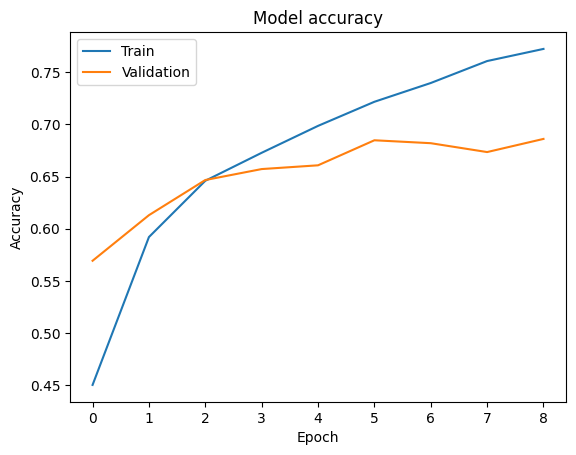

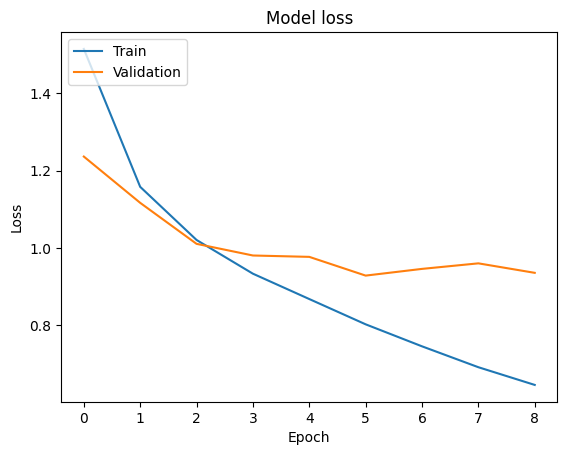

In [7]:
import matplotlib.pyplot as plt

# График точности модели
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# График потерь модели
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [8]:
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 48)        1344      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 48)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 48)        20784     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 48)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1728)              0         
                                                                 
 dense_6 (Dense)             (None, 96)               

**Пеерчислите алгоритмы поиска, реализованные в Keras-Tuner?**

Ваш ответ:

**Перечислите список параметров вашей гипермодели.**

Ваш ответ:

**Что такое Hyperband?**

Ваш ответ:

**Лучшая точность на тестовой выборке для вашей модели**

Ваш ответ:

**Лучшая архитектура для вашей модели**

Ваш ответ:
